In [171]:
# AIM OF THIS NOTE BOOK

## optional - download dataset
# https://cs.stanford.edu/~acoates/stl10/
# wget https://raw.githubusercontent.com/mttk/STL10/master/stl10_input.py
# python stl10_input.py

## generate random lines

## overlay lines to images

## train yolo with images with line

In [176]:
%load_ext autoreload
%autoreload 2

import traceback
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [177]:
from make_line import make_one_sample

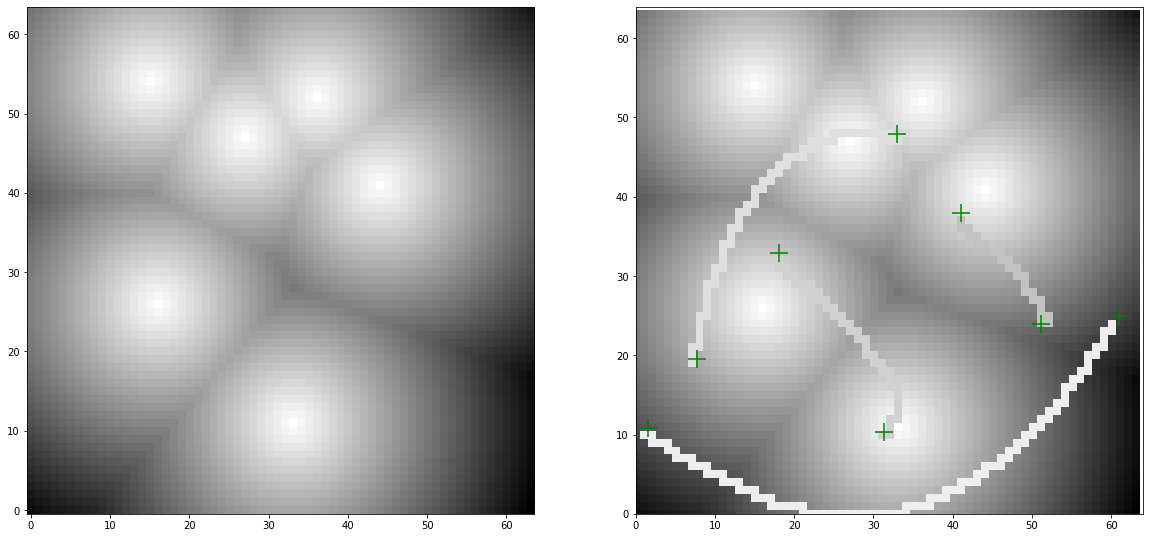

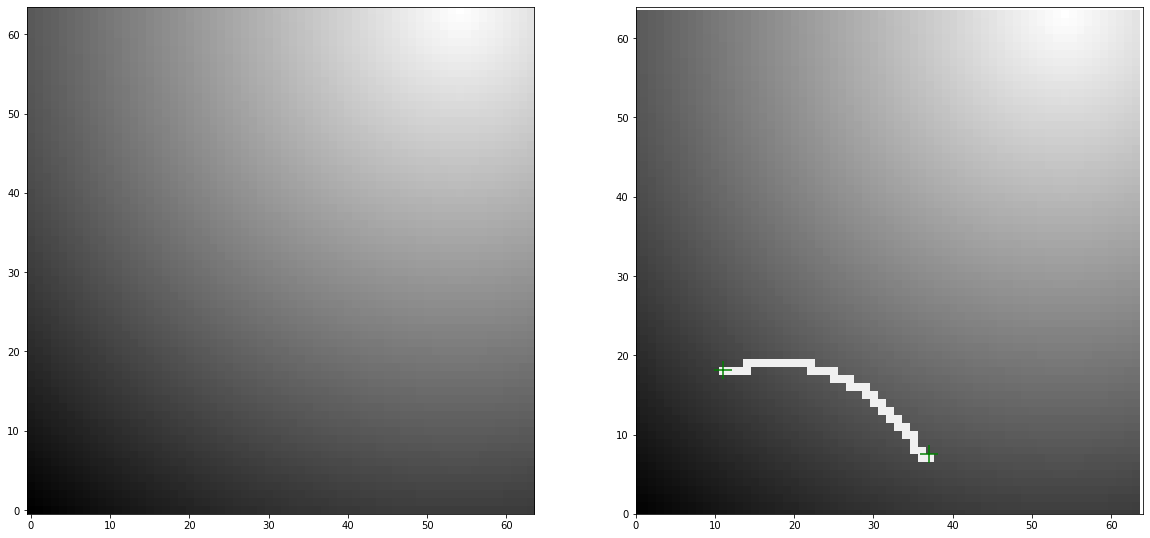

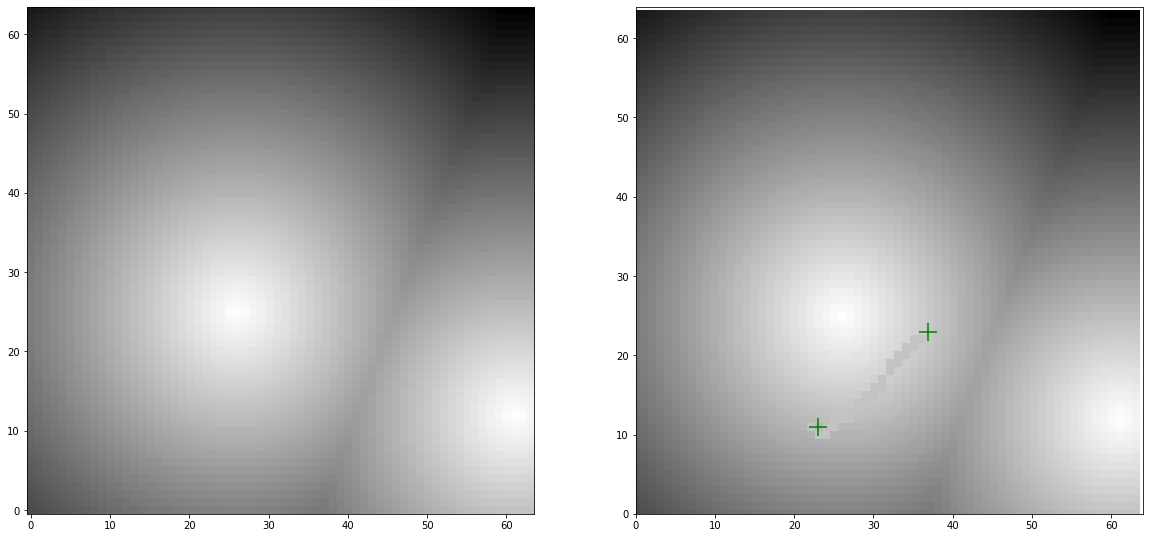

In [181]:
for n in range(3):
    try:
        terrain, container = make_one_sample(nx=64,ny=64,minlen=10,
            isplot=True,fignum=n,)
    except:
        pass
        traceback.print_exc()

In [ ]:
szx,szy,szz=64,64,64
smx,smy=8,8
grid = np.zeros((szx,szy)).astype(np.uint)

anchor_dict={}
for x in range(szx):
    for y in range(szy):
        px = x//smx
        py = y//smy
        code = py + smx*px
        if code not in anchor_dict.keys():
            anchor_dict[code]=(x,y)
        grid[x,y]=code
        
plt.imshow(grid)
print(np.unique(grid))

In [ ]:
# x  (None,64,64)
# y0 (None,64,5)     - object,relstartx,relstarty,shapex,shapey
# y1 (None,64,64,64) - 64x(64,64) mask

In [ ]:
def make_data(N=5):
    X0 = np.zeros((N,szx,szy)).astype(np.uint8)
    Y0 = np.zeros((N,szz,5)).astype(np.float)
    Y1 = np.zeros((N,szx,szy,szz)).astype(np.uint8)

    c=0
    for n in range(N*100):
        try:
            # make random line
            terrain, container = make_one_sample(nx=64,ny=64,minlen=10)
            # rescale input image
            terrain = (255*(terrain-np.max(terrain))/(np.max(terrain)-np.min(terrain))).astype(np.uint8)
            # for each line
            for row in container:
                # get mask and end points
                mask=row['mask'].astype(np.uint8)
                endpoints = np.array(row['endpoints']).astype(np.int)
                x0,y0=endpoints[0,:]
                x1,y1=endpoints[1,:]
                # ensure end points in line
                #assert(mask[x0,y0]==1 and mask[x1,y1]==1)

                istube=1
                # find min max point
                mask_indices = np.argwhere(mask>0)

                minx=np.min(mask_indices[:,0])
                miny=np.min(mask_indices[:,1])

                maxx=np.max(mask_indices[:,0])
                maxy=np.max(mask_indices[:,1])

                medx=np.median(mask_indices[:,0]).astype(np.int)
                medy=np.median(mask_indices[:,1]).astype(np.int)

                ind = grid[minx,miny]
                # get anchor in grid
                anchorx,anchory=anchor_dict[ind]
                # get rel start
                relstartx = minx-anchorx
                relstarty = miny-anchory
                # rel x
                relendx = maxx-minx
                relendy = maxy-miny
                # assign ys
                relstartx /= szx
                relstarty /= szy
                relendx /= szx
                relendy/= szy
                yolo = np.array([istube,relstartx,relstarty,relendx,relendy])
                #print(Y0[c,ind,:].shape,yolo.shape)
                
                Y0[c,ind,:]=yolo
                Y1[c,ind,:,:]=mask
            
            X0[c,:,:]=terrain
        
        except:
            if c >= N:
                break
            X0[c,:,:]=0
            Y0[c,:,:]=0
            Y1[c,:,:,:]=0
        
        if c>=N:
            break
        
        c+=1
        
    return X0,Y0,Y1


In [12]:
X0,Y0,Y1 = make_data(N=5)
c=0
ind = 0
for aind in range(smx*smy):    
    y0 = Y0[ind,aind,:]
    istube,relsx,relsy,relex,reley = y0
    if istube == 0:
        continue
    
    tmp = Y1[ind,aind,:,:]
    
    ax,ay = anchor_dict[aind]
    
    startx = ax+relsx*szx
    starty = ay+relsy*szy
    
    endx = startx+relex*szx
    endy = starty+reley*szy
    
    startx = startx.astype(np.int)
    starty = starty.astype(np.int)
    endx = endx.astype(np.int)
    endy = endy.astype(np.int)
    
    tmp[ax,ay]=2
    tmp[startx,starty]=3
    tmp[endx,endy]=3

    plt.figure(c)    
    plt.title('{}'.format(y0))
    plt.imshow(tmp,cmap='gray',origin='upper')    
    c+=1
    
plt.figure(c)
plt.imshow(X0[ind,])

In [13]:
x_train, y_train0, y_train1 = make_data(N=1000)
x_train = np.expand_dims(x_train,axis=-1)
x_val, y_val0, y_val1 = make_data(N=100)
x_val = np.expand_dims(x_val,axis=-1)

In [14]:
ind = -3
plt.subplot(121)
plt.imshow(x_train[ind,:].squeeze())
region = np.argwhere(y_train0[ind,:,0]==1)[0][0]
plt.subplot(122)
plt.imshow(y_trai1[ind,region,:,:])


In [15]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

from keras.models import Sequential, load_model
from keras import optimizers as opt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Reshape
from keras.callbacks import LearningRateScheduler


Using TensorFlow backend.


In [158]:


# simple yolo
#   https://gist.github.com/msrks/ce613e91a98868d4a059c6c5c5e30ba3
# vanillay conv cannot prediction coord
#   https://eng.uber.com/coordconv/
# alternative archetecture.
#   https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e
#   https://github.com/jianing-sun/Mask-YOLO



lambda_pos = 1.0

def yolo_loss(y_true, y_pred):
    
    loss = tf.Variable(tf.zeros([1]))
    for n in range(smx*smy):
        loss_obj = tf.keras.backend.binary_crossentropy(y_true[:,n,0], y_pred[:,n,0])
        
        loss_st_x = tf.squared_difference(y_true[:,n,1], y_pred[:,n,1])
        loss_st_y = tf.squared_difference(y_true[:,n,2], y_pred[:,n,2])
        loss_sz_x = tf.squared_difference(y_true[:,n,3], y_pred[:,n,3])
        loss_sz_y = tf.squared_difference(y_true[:,n,4], y_pred[:,n,4])

        loss_pos = tf.multiply(tf.multiply(lambda_pos, y_true[:,n,0]),tf.add(loss_st_x,loss_st_y))
        loss_sz = tf.multiply(tf.multiply(lambda_pos, y_true[:,n,0]),tf.add(loss_sz_x,loss_sz_y))
        newloss = tf.add(loss_obj,tf.add(loss_pos,loss_sz))
        loss = tf.add(loss,newloss)
    loss = tf.add(loss,newloss)
    return tf.reduce_mean(loss)
    '''
    
    #shape = y_true.get_shape().as_list()
    #dim = np.prod(shape[1:])    
    #y_true = tf.reshape(y_true, [-1, dim])
    #y_pred = tf.reshape(y_pred, [-1, dim])
    
    loss_obj = tf.keras.backend.binary_crossentropy(y_true[:,:,0], y_pred[:,:,0])
    loss_st_x = tf.squared_difference(y_true[:,:,1], y_pred[:,:,1])
    loss_st_y = tf.squared_difference(y_true[:,:,2], y_pred[:,:,2])
    loss_sz_x = tf.squared_difference(y_true[:,:,3], y_pred[:,:,3])
    loss_sz_y = tf.squared_difference(y_true[:,:,4], y_pred[:,:,4])

    loss_pos = tf.multiply(tf.multiply(lambda_pos, y_true[:,:,0]),tf.add(loss_st_x,loss_st_y))
    loss_sz = tf.multiply(tf.multiply(lambda_pos, y_true[:,:,0]),tf.add(loss_sz_x,loss_sz_y))
    loss = tf.add(loss_obj,tf.add(loss_pos,loss_sz))
    return tf.reduce_mean(loss)
    '''
model = Sequential()

model.add(Conv2D(16, 3, input_shape=(szx,szy,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(16, 3))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(smx*smy*5))
model.add(Reshape((smx*smy,5)))
model.add(Activation('sigmoid'))
model.summary()
print(x_train.shape,y_train0.shape,y_train1.shape)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 62, 62, 16)        160       
_________________________________________________________________
activation_190 (Activation)  (None, 62, 62, 16)        0         
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 29, 29, 16)        2320      
_________________________________________________________________
activation_191 (Activation)  (None, 29, 29, 16)        0         
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 12, 12, 16)        2320      
__________

In [159]:
# opt.Adam, opt.RMSprop
model.compile(loss=yolo_loss, optimizer=opt.RMSprop(lr=0.001))
history = model.fit(x_train, y_train0,
                    batch_size=128, epochs=100,
                    verbose=1, validation_data=(x_val, y_val0))

Train on 1000 samples, validate on 100 samples
Epoch 1/100
1000/1000 [==============================] - 23s 23ms/step - loss: 64.0394 - val_loss: 36.1195
Epoch 2/100
1000/1000 [==============================] - 1s 543us/step - loss: 34.0367 - val_loss: 18.8620
Epoch 3/100
1000/1000 [==============================] - 1s 543us/step - loss: 24.2962 - val_loss: 14.5749
Epoch 4/100
1000/1000 [==============================] - 1s 537us/step - loss: 19.3086 - val_loss: 11.0684
Epoch 5/100
1000/1000 [==============================] - 1s 541us/step - loss: 17.0217 - val_loss: 10.6458
Epoch 6/100
1000/1000 [==============================] - 1s 550us/step - loss: 15.1044 - val_loss: 10.3221
Epoch 7/100
1000/1000 [==============================] - 1s 547us/step - loss: 14.3234 - val_loss: 10.2494
Epoch 8/100
1000/1000 [==============================] - 1s 541us/step - loss: 12.9474 - val_loss: 10.3242
Epoch 9/100
1000/1000 [==============================] - 1s 539us/step - loss: 12.1442 - val_loss

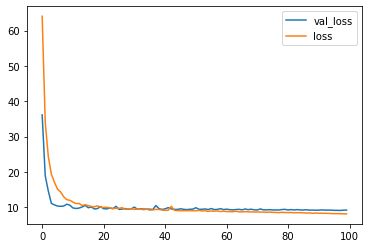

In [162]:
import pandas as pd
df = pd.DataFrame(history.history)
df.plot()

In [163]:
x_test, y_test0, y_test1 = make_data(N=5)
x_test = np.expand_dims(x_test,axis=-1)

In [164]:
#x_test, y_test0, y_test1 = x_train, y_train0, y_train1
pred = model.predict(x_test)

In [165]:
pred.shape

(5, 64, 5)

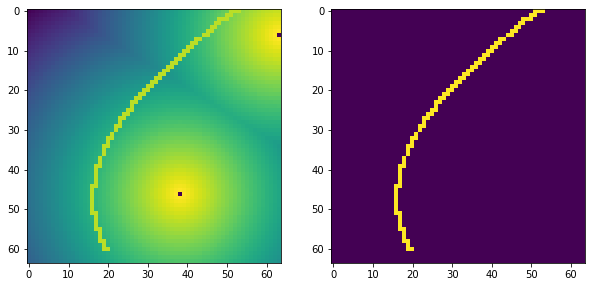

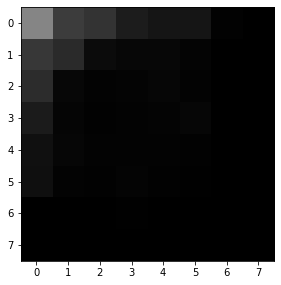

In [166]:
ind = 0
plt.figure(0,figsize=(10,10))
plt.subplot(121)
plt.imshow(x_test[ind,:].squeeze())
region = np.argwhere(y_test0[ind,:,0]==1)[0][0]
plt.subplot(122)
plt.imshow(y_test1[ind,region,:,:])
plt.figure(1,figsize=(10,10))
obj = np.reshape(pred[ind,:,0],(smx,smy))
plt.subplot(121)
plt.imshow(obj,vmin=0,vmax=1,cmap='gray')

In [ ]:
plt.plot(pred[ind,:,0])